#Questão 1 - Comparando uma implementação de  MLP com Graph Neural Networks 

Nesta questão, é feita uma implementação de uma MLP a fim de verificarmos o desempenho desta em relação às redes neurais de grafos. 

###Baixando o PyG e importando o dataset
O PyG é uma biblioteca que contém funcionalidades de processamento de redes neurais para grafos. Além disso, essa biblioteca contém um dataset, o cora, utilizado nesta modelagem de rede neural.

O cora é um dataset que representa citações entre artigos, cada um destes têm um gênero relacionado.1

In [ ]:
!pip install torch_geometric

     |████████████████████████████████| 407 kB 5.3 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=200c5ba9ef64fbefb7483331a6780338a419fef1b72316f1728a5a43e33d0a6e
  Stored in directory: /root/.cache/pip/wheels/18/a6/a4/ca18c3051fcead866fe7b85700ee2240d883562a1bc70ce421
Successfully built torch-geometric


In [ ]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-$TORCH_CUDA_VERSION.html

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 7.9 MB 5.2 MB/s 


In [ ]:
!pip install torch-sparse -f  https://data.pyg.org/whl/torch-$TORCH_CUDA_VERSION.html

Looking in links: https://data.pyg.org/whl/torch-.html
     |████████████████████████████████| 48 kB 2.8 MB/s 
  Created wheel for torch-sparse: filename=torch_sparse-0.6.13-cp37-cp37m-linux_x86_64.whl size=1590932 sha256=559f5571c7959a084f7f0a8b58142499deba1aa5dff27ce099605b03dfb784cb
  Stored in directory: /root/.cache/pip/wheels/e0/01/be/6b2966e0ff20bb023ae35e5d17903e6e5b4df46dd5892f6be6
Successfully built torch-sparse


###Importando as bibliotecas necessárias no trabalho

In [ ]:
import os
import numpy as np
import torch as torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split, TensorDataset
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
from torchvision import datasets, transforms
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from sklearn.preprocessing import LabelEncoder
from os.path import join
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
import os
# import EarlyStopping
#from pytorchtools import EarlyStopping
#from torchsample.callbacks import EarlyStopping
from matplotlib import pyplot

In [ ]:
os.environ['TORCH_CUDA_VERSION'] = torch.__version__

In [ ]:
!echo $TORCH_CUDA_VERSION

1.10.0+cu111


In [ ]:
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root='/tmp/Cora', name='Cora')

Processing...
Done!


###Inspecionando dataset

In [ ]:
print(f'Número de vértices (artigos): {dataset.data.num_nodes}')
print(f'Número de features (bag of words) : { dataset.num_node_features }')
print(f'Número de classes (subcampo de machine learning) : { dataset.num_classes }')

Número de vértices (artigos): 2708
Número de features (bag of words) : 1433
Número de classes (subcampo de machine learning) : 7


###Definindo a arquitetura do classificador

In [ ]:
class ClassField(nn.Module):
    # Construtor
    def __init__(self, input_size, hidden_size, out_size):
        super(ClassField, self).__init__()
        # primeira hidden layer - in_size = 
        # pois temos, para cada exemplo do dataset,  features de entrada.
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.dropout1 = nn.Dropout(0.5) 
        self.linear2 = nn.Linear(hidden_size, 50) # segunda hidden layer
        self.dropout2 = nn.Dropout(0.5) 
        self.linear3 = nn.Linear(50, out_size) # segunda hidden layer

    # Propagação (Feed Forward)
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.dropout1(x)
        x = self.linear2(x)
        x = F.relu(self.linear2(x))
        x = self.dropout2(x)
        x = self.linear3(x)
        return x

    #Funções auxiliares para calcular as métricas
    def accuracy(self, outputs, labels):
        _, preds = torch.max(outputs, dim=1)
        return torch.tensor(torch.sum(preds == labels).item() / len(preds))
    
    def validation_step(self, batch):
        examples, labels = batch 
        out = self(examples)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = self.accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
            
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def evaluate(model, val_loader):
        """Evaluate the model's performance on the validation set"""
        outputs = [model.validation_step(batch) for batch in val_loader]
        return model.validation_epoch_end(outputs)

    def epoch_end(self, epoch, result):
          print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

###Definindo os métodos de computação em GPU

In [ ]:
torch.cuda.is_available()
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()
device

device(type='cuda')

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)
def __len__(self):
        """Number of batches"""
        return len(self.dl)

###Dividindo o conjunto de dados em treino, validação e teste

In [ ]:
x_train = dataset.data.x[dataset.data.train_mask]
y_train = dataset.data.y[dataset.data.train_mask]

x_test = dataset.data.x[dataset.data.test_mask]
y_test = dataset.data.y[dataset.data.test_mask]

x_val = dataset.data.x[dataset.data.val_mask]
y_val = dataset.data.y[dataset.data.val_mask]

In [ ]:
batch_size = 128
train = TensorDataset(x_train, y_train)
train_loader = DataLoader(train, batch_size = batch_size, shuffle=True, num_workers=2, pin_memory=True)
train_loader = DeviceDataLoader(train_loader, device)

test = TensorDataset(x_test, y_test)
test_loader = DataLoader(test, batch_size = batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DeviceDataLoader(test_loader, device)

validation = TensorDataset(x_val, y_val)
val_loader = DataLoader(test, batch_size = batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DeviceDataLoader(val_loader, device)

###Implementação do earlyStopping

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience, verbose=True, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

###Definindo a etapa de treino do modelo

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

loss_fn = F.cross_entropy

def fit(epochs, learning_rate, model, train_loader, val_loader, opt_func=torch.optim.Adam):

    train_losses = []
    valid_losses = []
    avg_train_losses = []
    avg_valid_losses = [] 

    # Instânciar o Otimizador SGD
    optimizer =  opt_func(model.parameters(), lr=learning_rate)
    #definindo o early stopping
    es = EarlyStopping(patience=20, verbose=True)
  
    for epoch in range(epochs):
        #Aqui, colocamos o modelo em modo de treinamento, ou seja,
        #calculamos os gradientes (derivadas parciais)

        model.train() 
        for batch in train_loader:
            # Aqui, acessamos os dados de treino, obtidos do objeto "dataloader"
            X = batch[0]
            labels = batch[1]
            
            #Aqui, realizamos o FeedForward. 
            output = model(X)
            
            # Calcular erro usando a função-custo
            loss = loss_fn(output, labels)
            
            # Retro-propagação (Backpropagation). Nesta etapa são calculadas as derivadas parciais
            loss.backward()

            # Atualizar os parâmetros
            optimizer.step()  
            
            train_losses.append(loss.item())

            optimizer.zero_grad() #zerar os parâmetros para a próxima época


        # modo de validação #
        model.eval() 
        for batch in val_loader:
            input = batch[0]
            labels = batch[1]
            #Passo forward - Computar saídas previstas
            output = model(input)
            #calcular perda
            loss = loss_fn(output, labels)
            #histórico de custos de validação
            valid_losses.append(loss.item())

        #calcular custo médio por época - treino e validação
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(epochs))
        print_msg = (f'[{epoch:>{epoch_len}}/{epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        print(print_msg)
        
        #limpar as listas para armazenar os históricos da próxima época
        train_losses = []
        valid_losses = []
        
        # early_stopping precisa da perda de validação para checar se a ela diminuiu, 
        # se isso ocorrer, então teremos um checkpoint definido
        es(valid_loss, model)
        
        if es.early_stop:
            print("Early stopping")
            break
        
        # carregar o melhor checkpoint do último modelo
        model.load_state_dict(torch.load('checkpoint.pt'))
            
    return model, avg_train_losses, avg_valid_losses

Importante enfatizar, que a saída da rede tem tamanho 7, pois é o número de classes presentes.

In [ ]:
model = ClassField(input_size = dataset.num_node_features, hidden_size=50, out_size=7) 

to_device(model, device)

#history_t = []
#history_validation = []

model, avg_train_loss, avg_valid_loss = fit(epochs=100, learning_rate = 0.001, model = model, train_loader=train_loader, val_loader=val_loader)
#history_validation = [evaluate(model, val_loader)]

[  0/100] train_loss: 1.95867 valid_loss: 1.93529
Validation loss decreased (inf --> 1.935294).  Saving model ...
[  1/100] train_loss: 1.95513 valid_loss: 1.93475
Validation loss decreased (1.935294 --> 1.934748).  Saving model ...
[  2/100] train_loss: 1.95644 valid_loss: 1.93402
Validation loss decreased (1.934748 --> 1.934020).  Saving model ...
[  3/100] train_loss: 1.94579 valid_loss: 1.93447
EarlyStopping counter: 1 out of 20
[  4/100] train_loss: 1.93185 valid_loss: 1.93450
EarlyStopping counter: 2 out of 20
[  5/100] train_loss: 1.90960 valid_loss: 1.93444
EarlyStopping counter: 3 out of 20
[  6/100] train_loss: 1.93128 valid_loss: 1.93436
EarlyStopping counter: 4 out of 20
[  7/100] train_loss: 1.93192 valid_loss: 1.93470
EarlyStopping counter: 5 out of 20
[  8/100] train_loss: 1.97192 valid_loss: 1.93427
EarlyStopping counter: 6 out of 20
[  9/100] train_loss: 1.94058 valid_loss: 1.93438
EarlyStopping counter: 7 out of 20
[ 10/100] train_loss: 1.93551 valid_loss: 1.93431
Ear

###Exibição das métricas

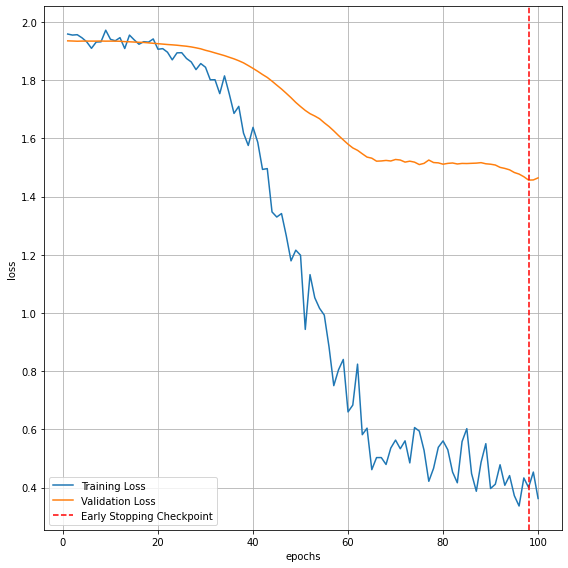

In [ ]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(8,8))
plt.plot(range(1,len(avg_train_loss)+1), avg_train_loss, label='Training Loss')
plt.plot(range(1,len(avg_valid_loss)+1), avg_valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = avg_valid_loss.index(min(avg_valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

In [ ]:
# initialize lists to monitor test loss and accuracy
perda_teste = 0.0
classes_corretas = list(0. for i in range(10))
total = list(0. for i in range(10))

print(dataset.data.y.unique())

classes = ['Case_Based', 'Genetic_Algorithms','Neural_Networks','Probabilistic_Methods','Reinforcement_Learning','Rule_Learning','Theory']

model.eval() # prep model for evaluation
for batch in test_loader:
    data = batch[0] 
    target = batch[1]

    if len(target.data) != batch_size:
        break
    #Passo forward - computar saídas previstas
    output = model(data)
    #calcular o custo
    loss = loss_fn(output, target)
    # update test loss 
    perda_teste += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    #comparar previsões com o target
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    #acurácia no teste
    for i in range(batch_size):
        label = target.data[i]
        classes_corretas[label] += correct[i].item()
        total[label] += 1

#calcular a perda média no teste
perda_teste = perda_teste/len(test_loader.dl.dataset)
print('Test Loss: {:.6f}\n'.format(perda_teste))

for i in range(7):
    if total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * classes_corretas[i] / total[i],
            np.sum(classes_corretas[i]), np.sum(total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(classes_corretas) / np.sum(total),
    np.sum(classes_corretas), np.sum(total)))

tensor([0, 1, 2, 3, 4, 5, 6])
Test Loss: 1.305870

Test Accuracy of     0: 50% (58/116)
Test Accuracy of     1: 59% (48/81)
Test Accuracy of     2: 67% (87/129)
Test Accuracy of     3: 31% (87/277)
Test Accuracy of     4: 53% (73/136)
Test Accuracy of     5: 58% (54/93)
Test Accuracy of     6: 60% (39/64)

Test Accuracy (Overall): 49% (446/896)


#Questão 2 - Colorindo imagens com o algoritmo "beta-version" do problema de colorização de imagens

In [ ]:
!pip install Poutyne

     |████████████████████████████████| 210 kB 3.2 MB/s 
     |████████████████████████████████| 397 kB 30.6 MB/s 


Esta questão consiste na reprodução de um tutorial, em especial da versão beta de uma rede neural que realiza coloração de imagens que estão em preto e branco. 

Esta versão resolve um problema da versão alfa, que é colorir imagens nunca antes conhecidas por esta rede. O trabalho a ser feito é uma tradução deste algoritmo, que é implementado utilizando a biblioteca Keras, para a implementação utilizando a biblioteca pytorch.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import random 
import os 
from tqdm import tqdm 
import plotly.io as pio
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,random_split, Dataset
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.manifold import TSNE
import plotly.express as px
from skimage import color
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave
#from keras.preprocessing.image import load_img
#para tornar possível a tradução "ao pé da letra" de keras para pytorch
#from poutyne import Model
#import torchmetrics
import natsort
from PIL import Image


###Extração de features
A ideia do artigo nesta etapa é mostrar que a imagem de entrada deve ser escaneada, da esquerda para a direita, para a rede prever a cor de cada pixel.
Então é apresentado um exemplo de extração de fetures da imagem de uma moça, em especial, extração de detalhes de seu nariz. Para isso, devem ser aplicados filtros(operação de convolução). No caso do tutorial foram utilizados 64 filtros, que irão gerar 64 imagens após a convolução. Durante este processo são descartados os pixels que não correspondem a certos padrões da imagem.

É possível aplicar ainda mais e mais filtros quanto for possível, a fim de se detectar padrões mais complexos. O tutorial descreve os resultados que podem ser encontrados desta etapa.

Então é feita uma breve descrição do funcionamento de uma rede neural convolucional. Ela extrai as features, "esmiúça" elas, e depois, as recombinam para gerar uma imagem de saída, ou a resposta acerca de qual é a imagem de entrada. 

Então, a ideia da versão beta, além de tornar possível a coloração de imagens outrora desconhecidas, é permitir também esse processo, mas com mais possibilidades de cores. 






###Criar um dataset
Esta classe irá nos ajudar a criar um dataset customizado a partir do diretório disponível. Ela servirá para criarmos os datasets de treino e de teste.

**Fonte da implementação:** https://discuss.pytorch.org/t/how-to-load-images-without-using-imagefolder/59999/2

Para auxiliar na construção da solução, apliquei código da seguinte fonte:
https://colab.research.google.com/github/smartgeometry-ucl/dl4g/blob/master/colorization.ipynb#scrollTo=_gK9BP0XIYAY

In [ ]:
class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsort.natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image

NameError: ignored

###Criação dos datasets e pré-processamento das imagens

Aqui, criei um quarto dataset, apenas para verificar como a rede irá se comportar com imagens em preto e branco nunca vistas antes. 

In [ ]:
from keras_preprocessing.image.utils import img_to_array
from torchvision.datasets import ImageFolder

#converte o objeto PIL image(uma imagem) para um tensor pytorch contendo 
#um LAB image 
def import_image(img):
    return torch.FloatTensor(np.transpose(color.rgb2lab(np.array(img)), (2, 0, 1)))
    
img_transform = transforms.Compose([
    transforms.Lambda(import_image)
])

dataset_train = CustomDataSet('Train/', transform=img_transform)
train_loader = DataLoader(dataset_train, batch_size=50, shuffle=True)

dataset_val = CustomDataSet('Validation/', transform=img_transform)
val_loader = DataLoader(dataset_val, batch_size=50, shuffle=True)

dataset_test = CustomDataSet('Test/', transform=img_transform)
test_loader = DataLoader(dataset_test, batch_size=50, shuffle=True)

dataset_test_others = CustomDataSet('TestOthers/', transform=img_transform)
test_loader_others = DataLoader(dataset_test_others, batch_size=50, shuffle=True)

In [ ]:
use_gpu = True

###Definindo a arquitetura da rede
Aqui, procuramos manter a similaridade sintática e de operações com a arquitetura definida no turorial. A arquitetura está definida de uma forma que mantenha a proporção da imagem a medida que a mesma percorre a rede. Por isso não temos camadas de maxpooling, pois, de acordo com o tutorial, essas camadas aumentam a densidade da informação, mas distorcem a imagem. Ao passo que, na maior parte da rede, a kernel possui um stride de 2, para que o resultado dessas camadas tivesse o tamanho reduzido pela metade, mantendo o propósito do tutorial nesse aspecto. A ideia é ter o aumento da densidade da informação, mas sem distorcer a imagem.

Outro aspecto é o padding. Para se estabelecer algum paralelo com o tutorial, ficamos com um padding de 1 ao longo desta arquitetura. Com esta configuração, a proporção da imagem pode permanecer constante ao longo da rede. 

Nas etapas finais da convolução, utilizamos algumas etapas de convolução transposta. De acordo com a documentação no pytorch, esse tipo de convolução é conhecida como uma espécie de "deconvolução", embora não chega a ser uma de fato. Ela pode ser melhor definida como uma convolução fracionada ou uma espécie de inverso de uma convolução. A imagem abaixo descreve um tipo de convolução transposta:
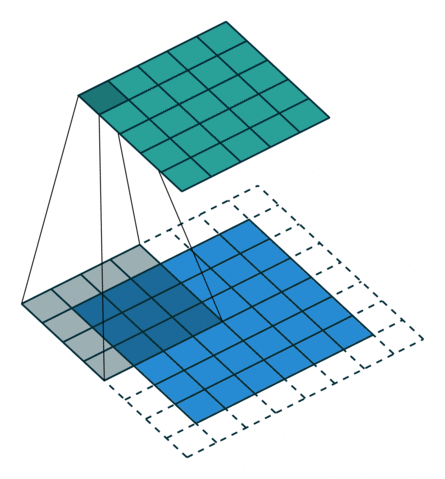

A animação pode ser vista nesse link: https://github.com/vdumoulin/conv_arithmetic/blob/master/gif/arbitrary_padding_no_strides_transposed.gif

Um outro aspecto diferente que se encontra presente aqui são as camadas de "BatchNorm2d". Elas servem para que haja uma regularização do modelo, para evitar overfitting.


In [ ]:
class Colorizer(nn.Module):
    def __init__(self, d=128):
        super(Colorizer, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1) 
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1) 
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1) 
        self.conv3_bn = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1) 
        self.conv4_bn = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1) 
        self.conv5_bn = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1) 
        self.conv6_bn = nn.BatchNorm2d(128)
        self.tconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1) 
        self.tconv1_bn = nn.BatchNorm2d(64)
        self.tconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1) 
        self.tconv2_bn = nn.BatchNorm2d(32)
        self.tconv3 = nn.ConvTranspose2d(32, 2, kernel_size=4, stride=2, padding=1) 

    def forward(self, input):
        x = F.relu(self.conv1_bn(self.conv1(input)))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.relu(self.conv4_bn(self.conv4(x)))
        x = F.relu(self.conv5_bn(self.conv5(x)))
        x = F.relu(self.conv6_bn(self.conv6(x)))
        x = F.relu(self.tconv1_bn(self.tconv1(x)))
        x = F.tanh(self.tconv2_bn(self.tconv2(x)))
        x = self.tconv3(x)

        return x

colorizer = Colorizer()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
colorizer = colorizer.to(device)

###Treinando o modelo
A rede reproduzida aqui tem como objetivo mapear os pixels da imagem de entrada, do espaço RGB para o espaço LAB. O mapeamento é feito através das operações de convolução. 

Ao longo do código, podemos ver operações de slices ":". Isso serve para realizarmos operações selecionando cada camada das imagens previstas. 

Na etapa de pré-processamento e carga dos datasets, alteramos os canais de cores, de RGB para LAB. Este último significa o seguinte: **L:** leveza, **a** e **b** os espectros de cor verde-vermelho e azul-amarelo.

A imagem abaixo descreve "a cara" da saída da rede. Por isso, é feita a conversão para RGB mais à frente para uma melhor visualização da imagem. 


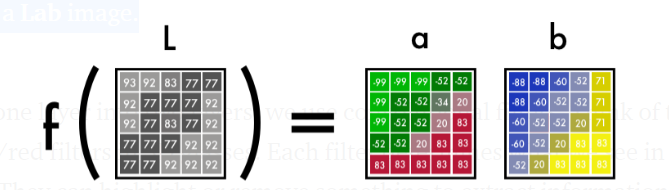
**Fonte :** https://emilwallner.medium.com/colorize-b-w-photos-with-a-100-line-neural-network-53d9b4449f8d

O que a rede faz, basicamente é desdobrar a imagem emduas camadas, por isso é feita a conversão de RGB para LAB no início. A rede desdobra as imagens sendo processadas da forma como a imagem acima descreve, através das operações de convolução dos filtros com os pixels da imagem de entrada. Esses filtros irão extrair diferentes detalhes da imagem, o modelo pode criar imagens a partir de um filtro, ou mesmo combinar diversoss filtros numa imagem.

Então, o que a rede irá fazer, após aprender os padrões de cores para cada detalhe das imagens aprendidas, é mapear os pixels de entrada para uma cor na saída. 

Um aspecto desta arquitetura, que também está implementado no tutorial, é a função de ativação próxima a saída da rede, a $tanh$ que tem sua faixa de saída limitada entre -1 e 1. Empiricamente, é comprovado que o uso desta função de ativação permite que a rede neural tenha uma melhor performance na coloração das imagens, pois aprende melhor a distribuição de cores das imagens de treino. 

A ReLU está presente na implementação da arquiterura da rede quase que em sua totalidade, e, ela também é boa em modelagem de alta resolução.




In [ ]:
learning_rate = 0.003
optimizer = torch.optim.Adam(params=colorizer.parameters(), lr=learning_rate)
num_epochs = 150

#modo de treinamento
colorizer.train()
train_loss_avg = []
print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0

    #aqui não desempacotamos dois itens pois não existe um target definido para cada imagem. A ideia aqui não é verificar o
    #acerto em relação a um target, mas verificar a capacidade do modelo em reconstruir e colorir imagens. Portanto,
    #temos um aprendizado não supervisionado
    for lab_batch in train_loader:
        
        lab_batch = lab_batch.to(device)
        
        #reconstrução e coloração da imagem através da rede 
        predicted = colorizer(lab_batch[:, 0:1, :, :])
        
        loss = F.mse_loss(predicted, lab_batch[:, 1:3, :, :])
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        #um passo na otimização
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] média de erro de reconstrução : %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [1 / 150] média de erro de reconstrução : 159.591276
Epoch [2 / 150] média de erro de reconstrução : 123.313282
Epoch [3 / 150] média de erro de reconstrução : 95.944514
Epoch [4 / 150] média de erro de reconstrução : 74.465680
Epoch [5 / 150] média de erro de reconstrução : 54.915121
Epoch [6 / 150] média de erro de reconstrução : 37.170716
Epoch [7 / 150] média de erro de reconstrução : 28.296770
Epoch [8 / 150] média de erro de reconstrução : 24.864782
Epoch [9 / 150] média de erro de reconstrução : 23.358902
Epoch [10 / 150] média de erro de reconstrução : 22.561596
Epoch [11 / 150] média de erro de reconstrução : 22.244944
Epoch [12 / 150] média de erro de reconstrução : 21.559282
Epoch [13 / 150] média de erro de reconstrução : 21.107379
Epoch [14 / 150] média de erro de reconstrução : 20.855287
Epoch [15 / 150] média de erro de reconstrução : 20.185187
Epoch [16 / 150] média de erro de reconstrução : 19.715991
Epoch [17 / 150] média de erro de reconstrução : 19.070515
Epoc

###Plotando curva de treino

A curva de aprendizado cai rapidamente até chegar num momento em que ela não ultrapassa uma média. Acredito que isto ocorra porque o dataset de treino contém imagens repetidas, e, além disso, a faixa de cores também é muito parecida, o que diminui a capacidade de aprendizado da rede, ela não é exposta a muita novidade, digamos assim.

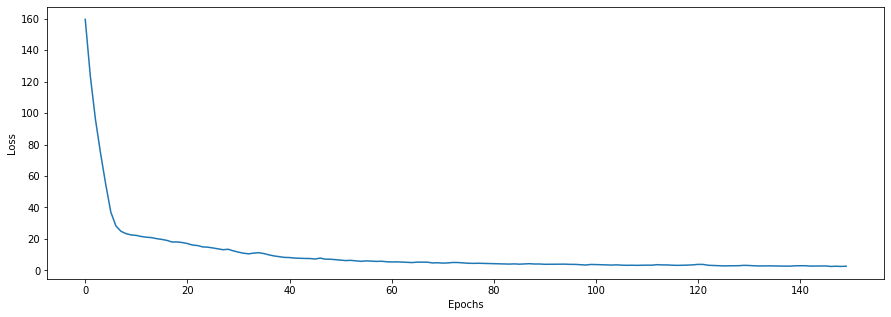

In [ ]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure(figsize=(15, 5))
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

###Avaliando no conjunto de validação

In [ ]:
# set to evaluation mode
colorizer.eval()
test_loss_avg, num_batches = 0, 0

for lab_batch in val_loader:
    with torch.no_grad():
        lab_batch = lab_batch.to(device)
        predicted_ab_batch = colorizer(lab_batch[:, 0:1, :, :])
        loss = F.mse_loss(predicted_ab_batch, lab_batch[:, 1:3, :, :])
        test_loss_avg += loss.item()
        num_batches += 1
    
test_loss_avg /= num_batches
print('average loss: %f' % (test_loss_avg))

average loss: 10.680785


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


###Colorindo no conjunto de teste

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


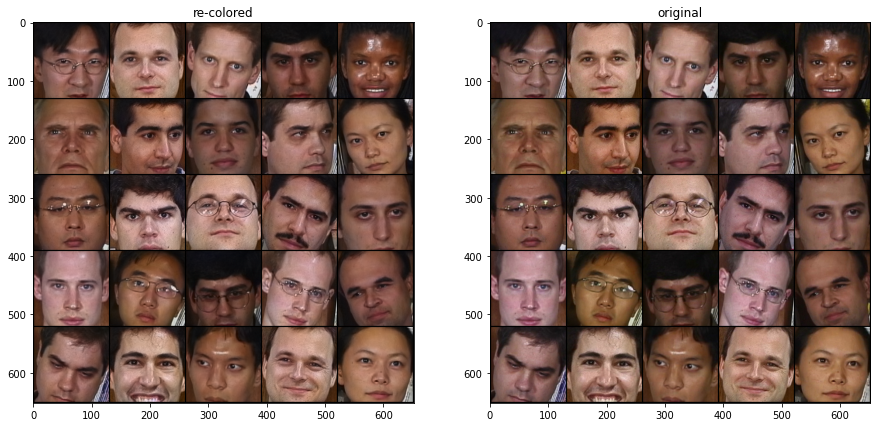

In [ ]:
import numpy as np
from skimage import color, io

import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

with torch.no_grad():
    #obter um conjunto de imagens aleatórias do conjunto de teste
    image_inds = np.random.choice(len(dataset_test), 25, replace=False)
    lab_batch = torch.stack([dataset_test[i] for i in image_inds])
    lab_batch = lab_batch.to(device)

    #prever cores em camadas ab
    predicted_ab_batch = colorizer(lab_batch[:, 0:1, :, :])
    predicted_lab_batch = torch.cat([lab_batch[:, 0:1, :, :], predicted_ab_batch], dim=1)

    lab_batch = lab_batch.cpu()
    predicted_lab_batch = predicted_lab_batch.cpu()

    #Converter para RGB
    rgb_batch = []
    predicted_rgb_batch = []
    for i in range(lab_batch.size(0)):
        rgb_img = color.lab2rgb(np.transpose(lab_batch[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
        rgb_batch.append(torch.FloatTensor(np.transpose(rgb_img, (2, 0, 1))))
        predicted_rgb_img = color.lab2rgb(np.transpose(predicted_lab_batch[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
        predicted_rgb_batch.append(torch.FloatTensor(np.transpose(predicted_rgb_img, (2, 0, 1))))

    #plotar as imagens
    fig, ax = plt.subplots(figsize=(15, 15), nrows=1, ncols=2)
    ax[0].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(predicted_rgb_batch), nrow=5).numpy(), (1, 2, 0)))
    ax[0].title.set_text('re-colored')
    ax[1].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(rgb_batch), nrow=5).numpy(), (1, 2, 0)))
    ax[1].title.set_text('original')
    plt.show()


###Teste com outras imagens
Aqui, decidi testar com imagens preto e branco para verificar o resultado. 

Uma observação é que na célula de código acima, parece muito óbvio tentar comparar as mesmas imagens, mas isso é relevante por dois motivos: Queremos avaliar a capacidade da rede em reconstruir as imagens, e, além disso, a rede pode recolorir as imagens com cores um pouco mais distorcidas, assim como podemos ver no notebook que utilizei como uma segunda referência: 

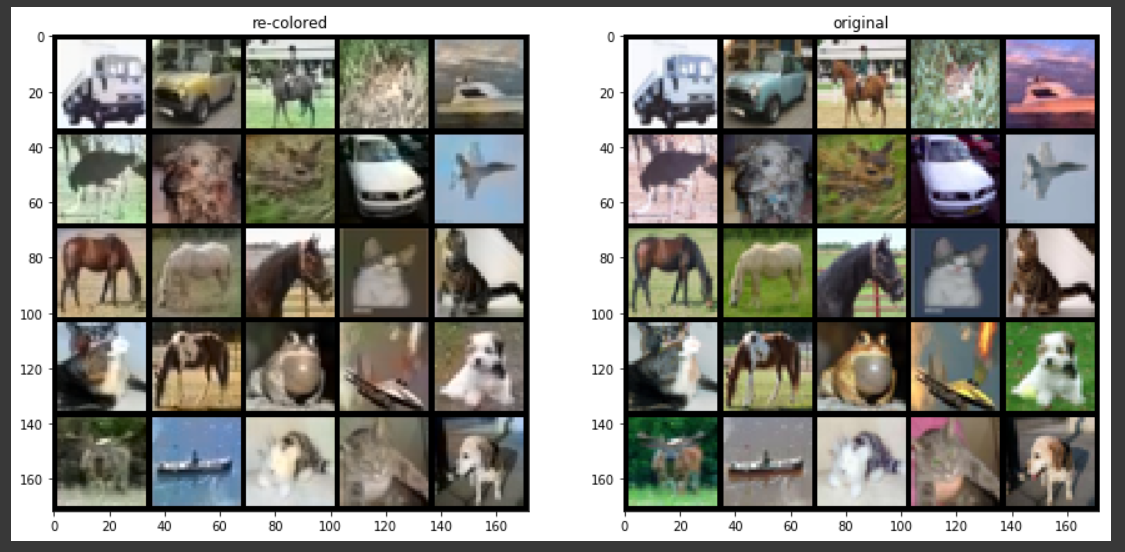

**Fonte :** https://colab.research.google.com/github/smartgeometry-ucl/dl4g/blob/master/colorization.ipynb#scrollTo=_gK9BP0XIYAY

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


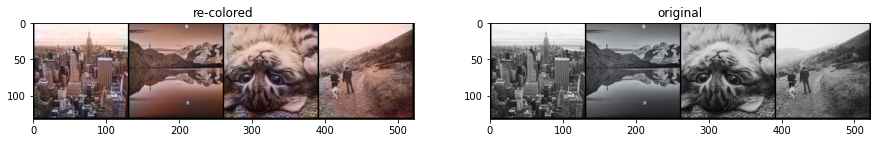

In [ ]:
import numpy as np
from skimage import color, io

import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

with torch.no_grad():
    # pick a random subset of images from the test set
    image_indexes = np.random.choice(len(dataset_test_others), 4, replace=False)
    lab_batch = torch.stack([dataset_test_others[i] for i in image_indexes])
    lab_batch = lab_batch.to(device)

    # predict colors (ab channels)
    predicted_ab_batch = colorizer(lab_batch[:, 0:1, :, :])
    predicted_lab_batch = torch.cat([lab_batch[:, 0:1, :, :], predicted_ab_batch], dim=1)

    lab_batch = lab_batch.cpu()
    predicted_lab_batch = predicted_lab_batch.cpu()

    #Converter para RGB
    rgb_batch = []
    predicted_rgb_batch = []
    for i in range(lab_batch.size(0)):
        rgb_img = color.lab2rgb(np.transpose(lab_batch[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
        rgb_batch.append(torch.FloatTensor(np.transpose(rgb_img, (2, 0, 1))))
        predicted_rgb_img = color.lab2rgb(np.transpose(predicted_lab_batch[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
        predicted_rgb_batch.append(torch.FloatTensor(np.transpose(predicted_rgb_img, (2, 0, 1))))

    # plot images
    fig, ax = plt.subplots(figsize=(15, 15), nrows=1, ncols=2)
    ax[0].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(predicted_rgb_batch), nrow=5).numpy(), (1, 2, 0)))
    ax[0].title.set_text('re-colored')
    ax[1].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(rgb_batch), nrow=5).numpy(), (1, 2, 0)))
    ax[1].title.set_text('original')
    plt.show()


Podemos ver que, apesar da rede ter uma taxa de erro de reconstrução baixo ao final do treinamento, a rede colore as imagens preto e branco para tons de marrom e bege. Isso se deve porque a rede aprende massivamente features de rostos de pessoas, que por sua vez estão nesta faixa de cores. A rede já consegue colorir imagens nunca vistas antes, então é um bom início. Se for trabalhada uma diversidade de imagens para o treino, o desempenho da rede será melhor. 